In [55]:
from collections import OrderedDict
from pathlib import Path
import multiprocessing
import contextlib

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.spatial.distance import hamming
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def print_alignment(seq1, seq2):
    alignment = pairwise2.align.globalxx(seq1, seq2)
    print(pairwise2.format_alignment(*alignment[0]))
    

data_path = Path('../data')
!ls $data_path

clustering	 stability_diversity.csv	stability_train.csv
mmseq		 stability_embeddings.pkl	stability_train_diversity.csv
mmseq_q		 stability.h5			stability_train_embeddings.pkl
mmseq_t		 stability_test.csv		stability_train.h5
raw		 stability_test_diversity.csv	tmp
sequences.fasta  stability_test_embeddings.pkl
stability.csv	 stability_test.h5


In [56]:
data = pd.read_csv(data_path / "stability.csv")
data.columns = ["consensus_stability_score", "sequences"]
data

,consensus_stability_score,sequences
0,0.37,GSSQETIEVEDEEEARRVAKELRKKGYEVKDERRGNKWHVHRT
1,0.62,TLDEARELVERAKKEGTGMDVNGQRFEDWREAERWVREQEKNK
2,-0.03,TELKKKLEEALKKGEEVRVKFNGIEIRNTSEDAARKAVELLEK
3,1.41,GSSQETIEVEDEEEARRVAKELRKTGYEVKIERRGNKWHVHRT
4,1.11,TTIHVGDLTLKYDNPKKAYEIAKKLAKKYNLQVTIKNGKITVT
...,...,...
10276,1.59,GSSKTQYEYDTKEEAQKAYEKFKKQGIPVTITQKNGKWFVQVE
10277,0.78,TELKKALEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK
10278,1.26,SKDEAQREAERAIRSGNKEEARRILEEAGYSPEQAERIARKLG
10279,1.48,GSSKTQYEYDTKEEAQPAYEKFKKQGIPVTITQKNGKWFVQVE


## Data Duplication

In [57]:
len(data['sequences'].unique()) == len(data), data['sequences'].unique().shape, len(data)

(True, (10281,), 10281)

In [58]:
data = data.drop_duplicates()
data

,consensus_stability_score,sequences
0,0.37,GSSQETIEVEDEEEARRVAKELRKKGYEVKDERRGNKWHVHRT
1,0.62,TLDEARELVERAKKEGTGMDVNGQRFEDWREAERWVREQEKNK
2,-0.03,TELKKKLEEALKKGEEVRVKFNGIEIRNTSEDAARKAVELLEK
3,1.41,GSSQETIEVEDEEEARRVAKELRKTGYEVKIERRGNKWHVHRT
4,1.11,TTIHVGDLTLKYDNPKKAYEIAKKLAKKYNLQVTIKNGKITVT
...,...,...
10276,1.59,GSSKTQYEYDTKEEAQKAYEKFKKQGIPVTITQKNGKWFVQVE
10277,0.78,TELKKALEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK
10278,1.26,SKDEAQREAERAIRSGNKEEARRILEEAGYSPEQAERIARKLG
10279,1.48,GSSKTQYEYDTKEEAQPAYEKFKKQGIPVTITQKNGKWFVQVE


## Alignments

In [59]:
# %timeit pairwise2.align.localmx(data['sequences'][0], data['sequences'][1], 1, 0)

In [60]:
# %timeit pairwise2.align.globalxx(data['sequences'][0], data['sequences'][1])

## Score per metrics

* More unique values => more stability?
* Does sequence length matter?


In [61]:
def append_to_key(d, k, v):
    if k in d:
        values = d[k]
        values.append(v)
        d[k] = values
        
    else:
        d[k] = [v]
        
def compute_mean_scores(d):
    new_d = dict()
    for k in d:
        mean_score = np.mean(d[k])
        new_d[k] = (mean_score, len(d[k]))
        
    return  OrderedDict(sorted(new_d.items()))

score_per_length = dict()
score_per_uniqueness = dict()

for idx, (score, seq) in data.iterrows():
    # score_per_length
    size = len(seq)
    append_to_key(score_per_length, size, score)
    
    
    # score_per_uniqueness => score per number of unique aminoacids in each seq
    uniques = set(seq)
    unique_size = len(uniques)
    
    append_to_key(score_per_uniqueness, unique_size, score)
    
    # count unique aminoacids
    for amino in uniques:
        uniques.add(amino)

In [62]:
compute_mean_scores(score_per_length)

OrderedDict([(43, (1.0895151578073088, 9632)),
             (46, (0.5599999999999999, 649))])

In [63]:
compute_mean_scores(score_per_uniqueness)

OrderedDict([(11, (1.1446428571428573, 28)),
             (12, (1.1679087452471484, 526)),
             (13, (1.0954285714285716, 2275)),
             (14, (1.0452967140755274, 2039)),
             (15, (1.1669070735090152, 2163)),
             (16, (1.1413855421686747, 1328)),
             (17, (0.777331240188383, 637)),
             (18, (0.8991928251121075, 223)),
             (19, (0.8025988700564971, 1062))])

## By Score

In [64]:
sorted_train = data.sort_values(by='consensus_stability_score')
sorted_train = sorted_train.reset_index(drop = True)

In [65]:
print_alignment(sorted_train['sequences'][0], sorted_train['sequences'][1])
sorted_train.head(5)

RKWEE--IA-----ER----LREEFNIN-PEE-AREAVEKAGGNEEEAR--R-P---VK-------K--RL
       |      |     |        | | |  |  ||      |   | |   |        |  | 
-----TTI-KVNGQE-YTVPL-------SP-EQA--A--KA------A-KKRWPDYEV-QIHGNTYKVTR-
  Score=15



,consensus_stability_score,sequences
0,-0.26,RKWEEIAERLREEFNINPEEAREAVEKAGGNEEEARRPVKKRL
1,-0.13,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTYKVTR
2,-0.12,TELKKKREEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK
3,-0.11,GMADEEKLPPGWESRMSRSSGRVYYFNHITNASQWERPSGGSS
4,-0.10,GSSGSLSDEDFKAVFGMTRSAFANLPLWKQQNPKKEKGLFGSS


In [66]:
print_alignment(sorted_train['sequences'][len(sorted_train)-1], sorted_train['sequences'][len(sorted_train)-2])
sorted_train.tail(5)

GSSET-RYRFTDEEE-ARRAAKEWARRGYQVHVTQNGTYWEVEVR
||| | |||||| || |||||||||||||||||||||||||||||
GSS-TTRYRFTD-EEKARRAAKEWARRGYQVHVTQNGTYWEVEVR
  Score=41



,consensus_stability_score,sequences
10276,2.20,ERRKIEEIAKKLYQSGNPEAARKFLRKAGISEEEIERILQKAG
10277,2.20,GSSKTQYEYDTKEEAQKAYEKFKKQGIRVTITQKNGKWFVQVE
10278,2.28,GSSKTQYEYDTKEEAQKAYEKFKRQGIPVTITQKNGKWFVQVE
10279,2.47,GSSTTRYRFTDEEKARRAAKEWARRGYQVHVTQNGTYWEVEVR
10280,2.49,GSSETRYRFTDEEEARRAAKEWARRGYQVHVTQNGTYWEVEVR


## Subsampling techniques

* Diversity Maximizing: This is a greedy strategy which starts from the reference and adds the sequence with highest average hamming distance to current set of sequences.

* Diversity Minimizing: This strategy is equivalent to the Diversity Maximizing strategy, but adds the se- quence with lowest average hamming distance. It is used to explore the effects of diversity on model per- formance.

* HHFilter: This strategy applies hhfilter (Steinegger etal.,2019)withthe-diff Mparameter,whichre- turns M or more sequences that maximize diversity (the result is usually close to M). If more than M sequences are returned we apply the Diversity Maxi- mizing strategy on top of the output.

In [67]:
def compute_diversity(seq1, seq2, method="hamming"):
    if method == "alignment":
        method = pairwise2.align.globalxx
        diversity = method(seq1, seq2)
        diversity = diversity[0].score / max(len(seq1), len(seq2))

    elif method == "hamming":
        if len(seq1) != len(seq2):
            size = min(len(seq1), len(seq2))
            seq1 = seq1[:size]
            seq2 = seq2[:size]

        method = hamming
        # print(list(seq1), "\n" ,list(seq2))
        diversity = method(list(seq1), list(seq2))

    return diversity


def div_vs_all(sequence, other_sequences, method="hamming", reducer=np.nanmean):
    v_diversity = np.vectorize(lambda x: compute_diversity(sequence, x, method=method))
    if len(other_sequences) > 1:
        div_vs_all = v_diversity(other_sequences)
    else:
        print(f"Skipping {sequence}")
        return np.nan

    reduced_div_vs_all = reducer(div_vs_all) if len(div_vs_all) >= 1 else np.nan
    return reduced_div_vs_all


def dataset_diversity(sequences, method="hamming", reduce="mean", verbose=True):
    if reduce != "mean":
        raise NotImplementedError
    else:
        # nan results are due to different lengths
        reducer = np.nanmean

    reduced_divs = []
    if verbose:
        pbar = tqdm(total=len(sequences), miniters=1, smoothing=1)

    all_other_sequences = [
        np.concatenate((sequences[:idx], sequences[idx + 1 :]))
        for idx in range(len(sequences))
    ]

    with contextlib.closing(multiprocessing.Pool(4)) as pool:
        for sequence_idx, sequence in enumerate(sequences):
            other_sequences = all_other_sequences[sequence_idx]
            reduced_divs.append(
                pool.apply_async(div_vs_all, args=(sequence, other_sequences, method))
            )

    for idx, result in enumerate(reduced_divs):
        reduced_divs[idx] = result.get()
        if verbose:
            pbar.update(1)
            pbar.refresh()

    pool.join()

    if verbose:
        pbar.close()

    return reduced_divs


def get_cluster_diversity():
    rep_seqs = dict()
    rep_seq_glob = list((data_path / "clustering").glob("cluster_*_rep_seq.fasta"))
    print(rep_seq_glob)

    for rep_seqs_pth in rep_seq_glob:
        df_name = rep_seqs_pth.stem.split("_")[1]

        df = pd.DataFrame()

        sequences = [str(record.seq) for record in SeqIO.parse(rep_seqs_pth, "fasta")]
        sequences = np.random.choice(sequences, 3000)
        alignment = dataset_diversity(sequences, "alignment")
        hamming = dataset_diversity(sequences, "hamming")

        df["sequences"] = sequences
        df["alignment"] = alignment
        df["hamming"] = hamming

        rep_seqs[df_name] = df

    return rep_seqs

In [68]:
diversity_alignment = compute_diversity(
    data["sequences"].values[0],
    data["sequences"].values[11],
    "alignment",
)

diversity_hamming = compute_diversity(
    data["sequences"].values[0],
    data["sequences"].values[11],
    "hamming"
)

diversity_alignment, diversity_hamming,  data["sequences"].values[0],  data["sequences"].values[11]

(0.9534883720930233,
 0.046511627906976744,
 'GSSQETIEVEDEEEARRVAKELRKKGYEVKDERRGNKWHVHRT',
 'GSSQETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRI')

In [69]:
#diversities = dataset_diversity(np.random.choice(data["sequences"].values, 14245))

In [70]:
records = []
for row_idx, row in tqdm(data.iterrows(), total=len(data)):
    record = SeqRecord(
        Seq(row.sequences),
        id=str(row[0]),
        name=f"mutagenesis_{row_idx}",
        description="",
        annotations={"labels": row.consensus_stability_score}
    )
    records.append(record)
    if len(row.sequences) > 6000: print(row_idx)
    
SeqIO.write(records, data_path / "sequences.fasta", "fasta")

100%|██████████| 10281/10281 [00:00<00:00, 17919.42it/s]


10281

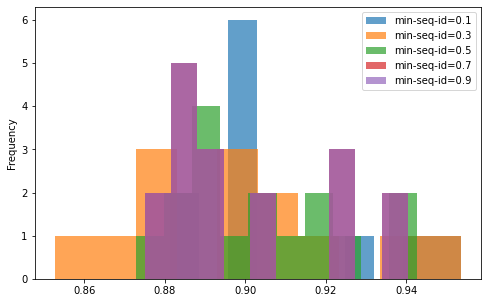

In [83]:
rep_seqs_diversity = dict()

rep_seqs_diversity_pths = list((data_path / "clustering").glob("diversity_*.csv"))

for pth in sorted(rep_seqs_diversity_pths):
    df_name = pth.stem.split("_")[1]
    rep_seqs_diversity[df_name] = pd.read_csv(pth)

f, axs = plt.subplots(ncols=1, figsize=(8,5))

for min_id, df in rep_seqs_diversity.items():
    df["hamming"].plot.hist(by="hamming", ax=axs, alpha=0.7)

axs.legend([f"min-seq-id={min_idty}" for min_idty, df in rep_seqs_diversity.items()]);

In [73]:
# ds_div_train = dataset_diversity(sets["train"]["sequence"])
# sets["train"]["diversity"] = np.nanmean(np.array(ds_div_train), 1)
# np.nanmean(np.array(ds_div_train))
# 0.8xxx

In [74]:
# ds_div_test = dataset_diversity(sets["test"]["sequence"])
# sets["test"]["diversity"] = np.nanmean(np.array(ds_div_test), 1)
# np.nanmean(np.array(ds_div_test))

In [75]:
# sets["train"].to_csv(f"{data_path}/stability_diversity_train.csv")
# sets["test"].to_csv(f"{data_path}/stability_diversity_test.csv")